# Polish Traffic Signs Recognition


In [18]:
# Global variables
DATA_PATH = './drive/MyDrive/PolishTrafficSignsRecognition/'
TRAIN_DATA_PATH = DATA_PATH + 'train/'
TEST_DATA_PATH = DATA_PATH + 'test/'
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES_200 = 22
NUM_CLASSES_100 = 42

# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import random

# DL imports
import keras
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

# 1. Data

## 1.1 Checking the data

### 1.1.1 Check if all signs are in both train & test dirs

In [3]:
train_signs_dirs = [dir for dir in os.listdir(TRAIN_DATA_PATH)]
test_signs_dirs = [dir for dir in os.listdir(TEST_DATA_PATH)]
print(f'Negative intersection train_signs_dirs ^ test_signs_dirs = {set(train_signs_dirs) ^ set(test_signs_dirs)}')
print(f'Number of classes train_signs_dirs: {len(train_signs_dirs)}')
print(f'Number of classes test_signs_dirs: {len(test_signs_dirs)}')

Negative intersection train_signs_dirs ^ test_signs_dirs = set()
Number of classes train_signs_dirs: 92
Number of classes test_signs_dirs: 92


So we know that both train and test sets have the same kinds of traffic signs


### 1.1.2 Check the number of train and test cases

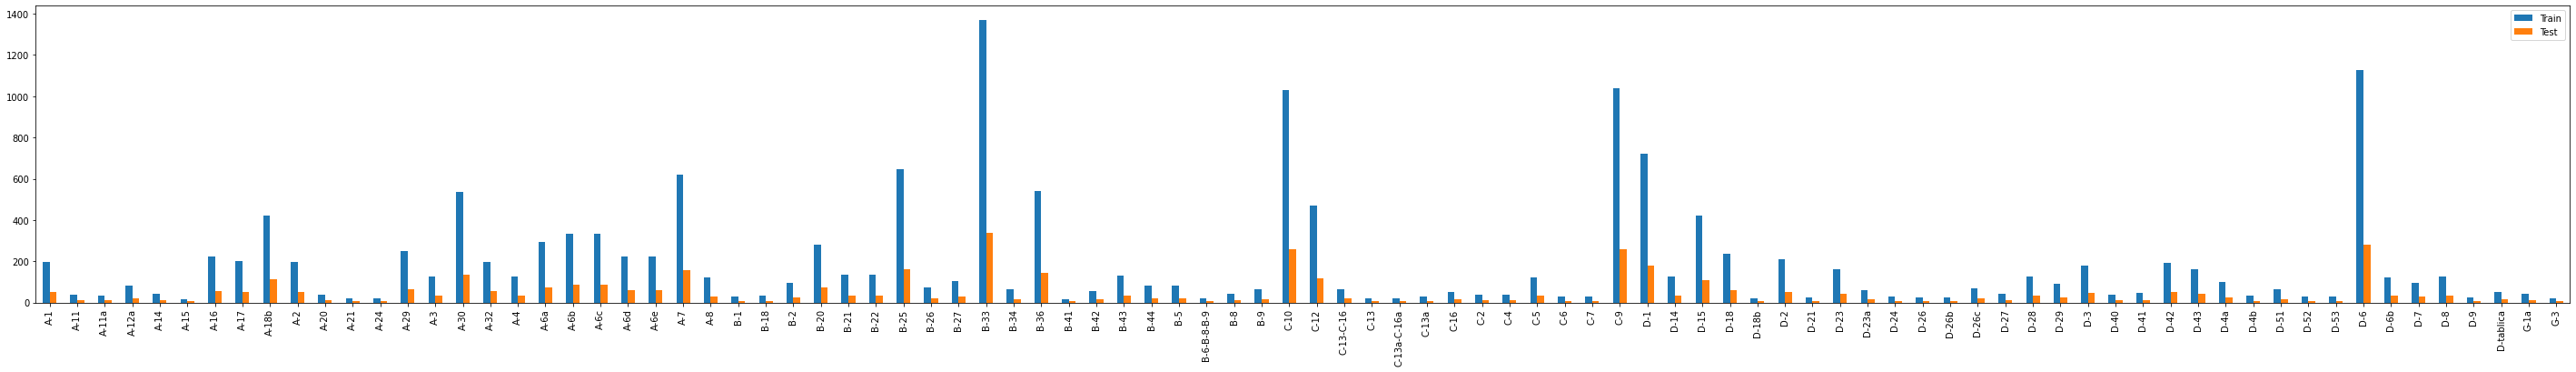



The lowest # of images in the train set dir: 15 
The highest # of images in the train set dir: 1370


In [4]:
train_signs_counts = [len(os.listdir(TRAIN_DATA_PATH + dir)) for dir in os.listdir(TRAIN_DATA_PATH)]
test_signs_counts = [len(os.listdir(TEST_DATA_PATH + dir)) for dir in os.listdir(TEST_DATA_PATH)]

df = pd.DataFrame(np.c_[train_signs_counts, test_signs_counts], index=train_signs_dirs)
df.plot.bar(figsize=(50,6))
plt.legend(['Train','Test'])
plt.show()

print(f'\n\nThe lowest # of images in the train set dir: {min(train_signs_counts)} \nThe highest # of images in the train set dir: {max(train_signs_counts)}')

As we see, the numbers of images of each traffic sign highly differ between themselves. Thus the given dataset is highly imbalanced.

#### Ways of deadling with imbalanced data

1. **Gather more data** - not really possible having in mind available time and energy for this project.
2. **Change performance metrics**  - accuracy is not the best performance metric when dealing with unbalanced data. That's why later in this project models will be also evaluated using //TODO
3. **Resampling Data** - both under-sampling and over-sampling will be used
4. **Data Augmentation** - will be used
5. **Different Algorithms** - as this project focuses on CNN this method will not be considered
6. **Penalization** - setting bigger weights on under-represented classes in order to put more pressure on classifing them correctly. It will be used in this project. 


Source: [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset ~ Jason Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

### 1.1.3 Check # of samples in specified ranges

In [6]:
# Checking the amount of the samples 

colective_count = np.zeros(5)
borders = [1000, 500, 400, 200, 100]
for count in train_signs_counts:
  for i in range(0, len(borders)):
    if count > borders[i]:
      colective_count[i] += 1

for i in range(0,5):
  print(f'Signs with # of train samples > {borders[i]} = {colective_count[i]}')
print(f'Signs with # of train samples <=100 = {len(train_signs_counts) - colective_count[-1]}')

Signs with # of train samples > 1000 = 4.0
Signs with # of train samples > 500 = 9.0
Signs with # of train samples > 400 = 12.0
Signs with # of train samples > 200 = 22.0
Signs with # of train samples > 100 = 42.0
Signs with # of train samples <=100 = 50.0


As we can see there are not a lot of classes with a lot of samples. In my further work I will use signs with >200 samples and >100 samples (with over-sampling and augmentation) to feed them into CNN.

### 1.1.4 Check train-test split ratio

In [7]:
# Checking the train-test split ratio

ratios = []
for i in range(0,len(train_signs_counts)):
  ratios.append(train_signs_counts[i]/(train_signs_counts[i] + test_signs_counts[i]))

print(f'Mean ratio of train/(train+test) = {np.mean(ratios)}, standard deviation = {np.std(ratios)}')

Mean ratio of train/(train+test) = 0.7884157455988144, standard deviation = 0.011628437254499458


As we can see training data makes around 80% of traffic sign samples. In order to obtain validation set, I will split test sets in half to obtain train-val-test ratio equal 80:10:10.

I take validation set from test set not training set, as I don't want to further reduce the number of samples available for network's training.

## 1.2 Preparing the data for CNNs

In [8]:
# Functions which will be used

def reshape_images(images):
  result = []
  for img in images:
    reshaped = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    result.append(reshaped)
  return result

def read_images(localization ,list_of_dirs, number_of_images_to_read, oversample = False, augment = False):
  result = []
  for dir in list_of_dirs:
    subresult = []
    i = 0
    for sign_image_name in os.listdir(os.path.join(localization,dir)):
      sign_image = mpimg.imread(os.path.join(localization, dir, sign_image_name))
      subresult.append((sign_image, dir))
      i += 1
      if i == number_of_images_to_read:
        break
    result += subresult
    if oversample:
      choices = np.random.choice(len(subresult), 200 - len(subresult))
      subresults += subresult[choices]
    if augment:
      generator = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=(0.5,1),
                             shear_range=20.0,
                             zoom_range=0.1,
                             channel_shift_range=100.0,
                             )
      augmented = []
      signs_length = len(subresult)
      j = 0
      while i < number_of_images_to_read:
        data = img_to_array(subresult[j % signs_length][0])
        samples = np.expand_dims(data, 0)
        it = generator.flow(samples, batch_size=1)
        batch = it.next()
        augmented.append((batch[0].astype('uint8'), dir))
        i += 1
        j += 1
      result += augmented
  return result

### 1.2.1 Loading images

In [9]:
dirs_above_200 = []
dirs_above_100 = []
for i in range(0, len(train_signs_dirs)):
  if train_signs_counts[i] > 200:
    dirs_above_200.append(train_signs_dirs[i])
  if train_signs_counts[i] > 100:
    dirs_above_100.append(train_signs_dirs[i])

In [ ]:
# Read >200
# train
images200_train = read_images(TRAIN_DATA_PATH, dirs_above_200, 200)
random.shuffle(images200_train)
# test
images200_test = read_images(TEST_DATA_PATH, dirs_above_200, 200)
random.shuffle(images200_test)
# valid
images200_valid = images200_test[:len(images200_train)//2]
images200_test = images200_test[len(images200_train)//2:]
# reshape
images200_train = reshape_images(images200_train)
images200_test = reshape_images(images200_test)
images200_valid = reshape_images(images200_valid)

In [ ]:
# Read >100 + over-sampling
# train
images100_sampled_train = read_images(TRAIN_DATA_PATH, dirs_above_100, 200, oversampled = True)
random.shuffle(images100_sampled_train)
# test
images100_sampled_test = read_images(TEST_DATA_PATH, dirs_above_100, 200)
random.shuffle(images100_sampled_test)
# valid
images100_sampled_valid = images100_sampled_test[:len(images100_sampled_test)//2]
images100_sampled_test = images100_sampled_test[len(images100_sampled_test)//2:]
# reshape
images100_sampled_train = reshape_images(images100_sampled_train)
images100_sampled_test = reshape_images(images100_sampled_test)
images100_sampled_valid = reshape_images(images100_sampled_valid)

In [30]:
# Read >100 + augmentation
# train
images100_augmented_train = read_images(TRAIN_DATA_PATH, dirs_above_100, 200, augment = True)
random.shuffle(images100_augmented_train)
# test
images100_augmented_test = read_images(TEST_DATA_PATH, dirs_above_100, 200)
random.shuffle(images100_augmented_test)
# valid
images100_augmented_valid = images100_augmented_test[:len(images100_augmented_test)//2]
images100_augmented_test = images100_augmented_test[len(images100_augmented_test)//2:]
# reshape
# images100_augmented_train = reshape_images(images100_augmented_train)
# images100_augmented_test = reshape_images(images100_augmented_test)
# images100_augmented_valid = reshape_images(images100_augmented_valid)

## 1.3 Data presentation

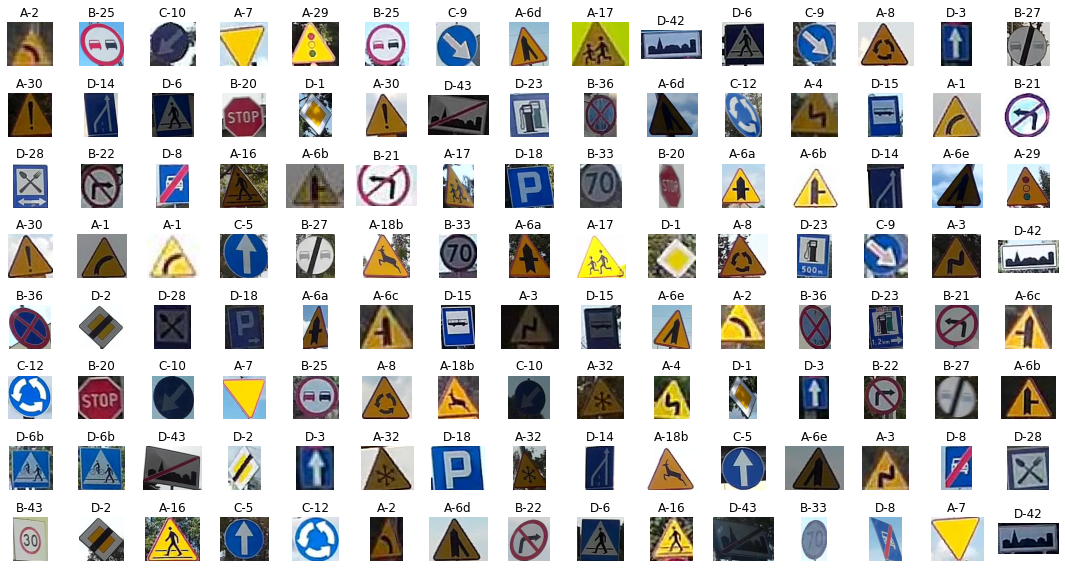

In [31]:
plt.rcParams['figure.figsize'] = (5, 5)
col = 15
row = 8
fig = plt.figure(figsize=(col, row))
for i in range(1,col*row + 1):
  fig.add_subplot(row, col, i)
  plt.axis('off')
  plt.imshow(images100_augmented_train[i][0])
  plt.title(f'{images100_augmented_train[i][1]}')
fig.tight_layout()
plt.show()

# 2. Learning

In [32]:
x_aug_100_train = [i[0] for i in images100_augmented_train]
y_aug_100_train = [i[1] for i in images100_augmented_train]
x_aug_100_train = reshape_images(x_aug_100_train)

In [33]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(NUM_CLASSES_100, activation='softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [34]:
encoder = LabelBinarizer()
y_aug_100_train_labels = encoder.fit_transform(y_aug_100_train)
x_aug_100_train = np.array(x_aug_100_train).astype('float32')
x_aug_100_train /= 255
x_aug_100_train = x_aug_100_train.reshape(x_aug_100_train.shape[0],28,28,3)

In [ ]:
model1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

history1 = model1.fit(x_aug_100_train, y_aug_100_train_labels, epochs = 50)

---

# Legacy code below - might be used later

### There is no point in running that cells - their outputs are rather irrelevant

In [ ]:
# RGB to Greyscale
# rgb_weights = [0.2989, 0.5870, 0.1140]
# res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC) # img[0]
# res2 = np.dot(res[...,:3], rgb_weights)
# res2 = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)[:,:,None]

reshaped_train_images = []
for img in signs_images:
  
  reshaped_train_images.append(res2)
a = reshaped_train_images
reshaped_train_images = np.array(reshaped_train_images)

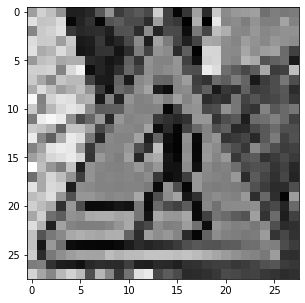

In [ ]:
a = reshaped_train_images[0]
a = np.squeeze(a)
plt.imshow(a, cmap='gray')

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        DATA_PATH+'train/',
        target_size=(100, 100),
        batch_size=20,
        class_mode='binary')
model1.fit(
        train_generator,
        steps_per_epoch=2000,
        epochs=50, verbose = 2)

Found 16746 images belonging to 92 classes.
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:706: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x, subok=True, copy=copy)


TypeError: ignored

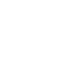

In [ ]:
def read_images(dir, augment = False, generator = None, number = 0):
  result = []
  for signs_dir in os.listdir(dir):
    i = 0
    signs = []
    # Read images
    for sign_image_name in os.listdir(os.path.join(dir, signs_dir)):
      sign_image = mpimg.imread(os.path.join(dir, signs_dir, sign_image_name))
      signs.append((sign_image,signs_dir))
      i += 1
      if i == number:
        break
    result += signs

    # Augment if needed
    if augment:
      augmented = []
      signs_length = len(signs)
      j = 0
      while i < number:
        data = img_to_array(signs[j % signs_length][0])
        samples = expand_dims(data, 0)
        it = generator.flow(samples, batch_size=1)
        batch = it.next()
        augmented.append((batch[0].astype('uint8'), signs_dir))
        i += 1
        j += 1
      result += augmented
  return result

# train_images = read_images(DATA_PATH + 'train', number = 5)
# test_images = read_images(DATA_PATH + 'test', number = 5)
# random.shuffle(train_images)
# random.shuffle(test_images)
# print(f'Number of read train images: {len(train_images)}')
# print(f'Number of read test images: {len(test_images)}')

plt.rcParams['figure.figsize'] = (5, 5)
col = 15
row = 4
fig = plt.figure(figsize=(col, row))
for i in range(1,col*row + 1):
  fig.add_subplot(row, col, i)
  plt.axis('off')
  plt.imshow(reshaped_train_images[i])
  plt.title(f'{new_train_names[i][1]}')
fig.tight_layout()
plt.show()

In [ ]:
gen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=(0.5,1),
                             shear_range=20.0,
                             zoom_range=0.1,
                             channel_shift_range=100.0,
                             )

train_images = read_images(DATA_PATH + 'train', augment=True, generator = gen, number = 20)
test_images = read_images(DATA_PATH + 'test', augment=True, generator = gen, number = 20)

In [ ]:
img = load_img('/content/drive/MyDrive/PolishTrafficSignsRecognition/test/A-1/2019_0719_142601_003 1954_0.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=(0.5,1),
                             shear_range=20.0,
                             zoom_range=0.1,
                             channel_shift_range=100.0,
                             )
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()


NameError: ignored